##### # Springboard Data Science Career Track

# Unit 5.2 - Working with Data in Files

# JSON exercise - August 5, 2019 vlbrown

**Goals**
 * Get familiar with packages for dealing with JSON.
 * Study examples that use JSON strings and files.
 * Work on an exercise to be completed and submitted.

**Tasks**

Using data in the file `data/world_bank_projects.json` and the techniques demonstrated above:

1. Find the 10 countries with the largest number of projects.
2. Find the top 10 major project themes (using the column `mjtheme_namecode`).
3. In step 2, you will notice that some entries have only the code (i.e. the name is missing). Create a dataframe with the missing names filled in.

 * reference: http://pandas.pydata.org/pandas-docs/stable/io.html#io-json-reader
 * data source: https://www.springboard.com/static/project_files/data_wrangling_json.zip


_For purposes of this exercise, the JSON code examples have been removed from this Notebook._

## Exercise Data: World Bank Projects

> World Bank Projects & Operations provides access to basic information on all of the World Bank's lending projects from 1947 to the present. The dataset includes basic information such as the project title, task manager, country, project id, sector, themes, commitment amount, product line, and financing. It also provides links to publicly disclosed online documents.
>
> World Bank data is organized around the concept of a project, with the project id being the key linking a project to additional related operational datasets such as contract awards, loans/credits/grants, trust funds, etc. (These datasets are not used in this exercise.)
>
> -- [World Bank datacatalog](https://datacatalog.worldbank.org/dataset/world-bank-projects-operations)

### Setup

In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_colwidth', 400)

### Load and explore the data.

In [2]:
# Load a file of JSON data as a pandas dataframe.
wb_all_df = pd.read_json('data/world_bank_projects.json')

In [3]:
# Display the column names.
wb_all_df.columns

Index(['_id', 'approvalfy', 'board_approval_month', 'boardapprovaldate',
       'borrower', 'closingdate', 'country_namecode', 'countrycode',
       'countryname', 'countryshortname', 'docty', 'envassesmentcategorycode',
       'grantamt', 'ibrdcommamt', 'id', 'idacommamt', 'impagency',
       'lendinginstr', 'lendinginstrtype', 'lendprojectcost',
       'majorsector_percent', 'mjsector_namecode', 'mjtheme',
       'mjtheme_namecode', 'mjthemecode', 'prodline', 'prodlinetext',
       'productlinetype', 'project_abstract', 'project_name', 'projectdocs',
       'projectfinancialtype', 'projectstatusdisplay', 'regionname', 'sector',
       'sector1', 'sector2', 'sector3', 'sector4', 'sector_namecode',
       'sectorcode', 'source', 'status', 'supplementprojectflg', 'theme1',
       'theme_namecode', 'themecode', 'totalamt', 'totalcommamt', 'url'],
      dtype='object')

In [4]:
# Display all of the data in the first row.
wb_all_df.head(1)

,_id,approvalfy,board_approval_month,boardapprovaldate,borrower,closingdate,country_namecode,countrycode,countryname,countryshortname,...,sectorcode,source,status,supplementprojectflg,theme1,theme_namecode,themecode,totalamt,totalcommamt,url
0,{'$oid': '52b213b38594d8a2be17c780'},1999,November,2013-11-12T00:00:00Z,FEDERAL DEMOCRATIC REPUBLIC OF ETHIOPIA,2018-07-07T00:00:00Z,Federal Democratic Republic of Ethiopia!$!ET,ET,Federal Democratic Republic of Ethiopia,Ethiopia,...,"ET,BS,ES,EP",IBRD,Active,N,"{'Percent': 100, 'Name': 'Education for all'}","[{'code': '65', 'name': 'Education for all'}]",65,130000000,130000000,http://www.worldbank.org/projects/P129828/ethiopia-general-education-quality-improvement-project-ii?lang=en


In [5]:
# Display summary information (e.g. data types) for the DF.
wb_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 50 columns):
_id                         500 non-null object
approvalfy                  500 non-null int64
board_approval_month        500 non-null object
boardapprovaldate           500 non-null object
borrower                    485 non-null object
closingdate                 370 non-null object
country_namecode            500 non-null object
countrycode                 500 non-null object
countryname                 500 non-null object
countryshortname            500 non-null object
docty                       446 non-null object
envassesmentcategorycode    430 non-null object
grantamt                    500 non-null int64
ibrdcommamt                 500 non-null int64
id                          500 non-null object
idacommamt                  500 non-null int64
impagency                   472 non-null object
lendinginstr                495 non-null object
lendinginstrtype            495 non

There are two ID columns: `_id` and `id`.

In [6]:
# Display the first three rows of `_id`.
wb_all_df._id.head(3)

0    {'$oid': '52b213b38594d8a2be17c780'}
1    {'$oid': '52b213b38594d8a2be17c781'}
2    {'$oid': '52b213b38594d8a2be17c782'}
Name: _id, dtype: object

In [7]:
# Display the first three rows of `id`.
wb_all_df.id.head(3)

0    P129828
1    P144674
2    P145310
Name: id, dtype: object

In [8]:
# Display the number of unique `id` values.
wb_all_df.id.nunique()

500

Every row has a unique `id`, which is a lot simpler than `_id`, so we'll use the `id` column.

## Plan

We want to:

 1. Find the 10 countries with the most projects (and, presumably, count the number of projects for each).
 2. Find the top 10 major project themes (using column `mjtheme_namecode`).
 3. Handle instances where the theme code is present but the theme name is missing, inserting the correct name in each case. 

For this project, we're interested in the following columns:

 * `id`, `project_name`
 * `countrycode`, `countryname`, `countryshortname`
 * `mjtheme`, `mjtheme_namecode`, `mjthemecode`


### Extract a new dataframe with only the columns of interest.

In [9]:
# Get an alias to the columns of interest.
wb_df = wb_all_df[['id', 'project_name',
                   'countrycode', 'countryname', 'countryshortname',
                   'mjtheme', 'mjtheme_namecode', 'mjthemecode'
                 ]]

In [10]:
# Display the first five rows.
wb_df.head()

,id,project_name,countrycode,countryname,countryshortname,mjtheme,mjtheme_namecode,mjthemecode
0,P129828,Ethiopia General Education Quality Improvement Project II,ET,Federal Democratic Republic of Ethiopia,Ethiopia,[Human development],"[{'code': '8', 'name': 'Human development'}, {'code': '11', 'name': ''}]","8,11"
1,P144674,TN: DTF Social Protection Reforms Support,TN,Republic of Tunisia,Tunisia,"[Economic management, Social protection and risk management]","[{'code': '1', 'name': 'Economic management'}, {'code': '6', 'name': 'Social protection and risk management'}]","1,6"
2,P145310,Tuvalu Aviation Investment Project - Additional Financing,TV,Tuvalu,Tuvalu,"[Trade and integration, Public sector governance, Environment and natural resources management, Social protection and risk management]","[{'code': '5', 'name': 'Trade and integration'}, {'code': '2', 'name': 'Public sector governance'}, {'code': '11', 'name': 'Environment and natural resources management'}, {'code': '6', 'name': 'Social protection and risk management'}]","5,2,11,6"
3,P144665,Gov't and Civil Society Organization Partnership,RY,Republic of Yemen,"Yemen, Republic of","[Social dev/gender/inclusion, Social dev/gender/inclusion]","[{'code': '7', 'name': 'Social dev/gender/inclusion'}, {'code': '7', 'name': 'Social dev/gender/inclusion'}]","7,7"
4,P144933,Second Private Sector Competitiveness and Economic Diversification Prj,LS,Kingdom of Lesotho,Lesotho,"[Trade and integration, Financial and private sector development]","[{'code': '5', 'name': 'Trade and integration'}, {'code': '4', 'name': 'Financial and private sector development'}]","5,4"


In [11]:
# Display summary information for the DF subset.
wb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
id                  500 non-null object
project_name        500 non-null object
countrycode         500 non-null object
countryname         500 non-null object
countryshortname    500 non-null object
mjtheme             491 non-null object
mjtheme_namecode    500 non-null object
mjthemecode         500 non-null object
dtypes: object(8)
memory usage: 31.3+ KB


## 1. Find the 10 countries with the most projects.

In [12]:
# Display the 10 countries with the most projects.
wb_top10_tmp = wb_df.filter(
                     items=['countrycode', 'countryshortname','id']
                   ).groupby(
                     ['countrycode', 'countryshortname']
                   ).count(). \
                     sort_values(
                     by=['id'], ascending=False
                   ).head(10)

wb_top10_df = wb_top10_tmp[['id']].rename(columns={"id": "Num_Projects"})

wb_top10_df

,,Num_Projects
countrycode,countryshortname,
ID,Indonesia,19
CN,China,19
VN,Vietnam,17
IN,India,16
RY,"Yemen, Republic of",13
MA,Morocco,12
BD,Bangladesh,12
NP,Nepal,12
3A,Africa,11


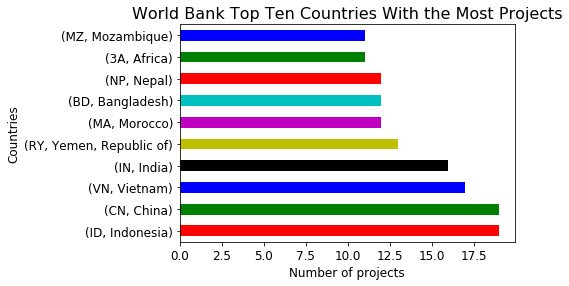

In [13]:
# Display a bar chart of the data.
bar_colors = 'rgbkymc'

ax = wb_top10_df.plot(kind='barh', legend=False, fontsize=12, color=bar_colors)

title = 'World Bank Top Ten Countries With the Most Projects'
ax.set_title(title, fontsize=16)
ax.set_ylabel('Countries', fontsize=12)
ax.set_xlabel('Number of projects', fontsize=12)

plt.show()

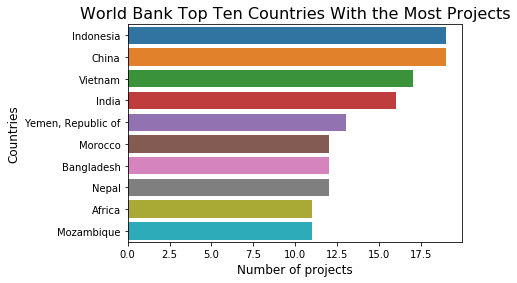

In [14]:
# Try Seaborn to see which kind of plot I prefer
ax = sns.barplot(x='Num_Projects', y='countryshortname', data=wb_top10_df.reset_index())
title = 'World Bank Top Ten Countries With the Most Projects'
ax.set_title(title, fontsize=16)
ax.set_ylabel('Countries', fontsize=12)
ax.set_xlabel('Number of projects', fontsize=12)
plt.show()



I have to say that Seaborn has nicer color options.

## 2. Find the top 10 major project themes (using column mjtheme_namecode).

First, examine the `mjtheme_namecode` column. The values are lists of dictionaries.

In [15]:
# Display the first five `mjtheme_namecode` values.
wb_df.mjtheme_namecode.head()

0                                                                                                                                                                       [{'code': '8', 'name': 'Human development'}, {'code': '11', 'name': ''}]
1                                                                                                                                 [{'code': '1', 'name': 'Economic management'}, {'code': '6', 'name': 'Social protection and risk management'}]
2    [{'code': '5', 'name': 'Trade and integration'}, {'code': '2', 'name': 'Public sector governance'}, {'code': '11', 'name': 'Environment and natural resources management'}, {'code': '6', 'name': 'Social protection and risk management'}]
3                                                                                                                                   [{'code': '7', 'name': 'Social dev/gender/inclusion'}, {'code': '7', 'name': 'Social dev/gender/inclusion'}]
4                                   

Many of the World Bank projects match more than one theme. Some claim to match the same theme more than once.


In [16]:
# Display a `mjtheme_namecode` value that has more than one theme.
wb_df.mjtheme_namecode[1]

[{'code': '1', 'name': 'Economic management'},
 {'code': '6', 'name': 'Social protection and risk management'}]

In [17]:
# Display a `mjtheme_namecode` value that has more than one theme.
wb_df.mjtheme_namecode[3]

[{'code': '7', 'name': 'Social dev/gender/inclusion'},
 {'code': '7', 'name': 'Social dev/gender/inclusion'}]

### Task: Find the top 10 major project themes. 

There are two ways to interpret this requirement:

  1) What are the top 10 sets of themes (i.e. group by project/theme set).

  2) What are the top 10 individual themes (i.e. group by theme).
  
I am going to assume option 2. Thus, we need to separate the groups of themes and count how many times each theme occurs.

**Note:** The data set appears to have issues, as some projects list the same theme more than once (e.g. P144665).
```
    [{'code': '7', 'name': 'Social dev/gender/inclusion'},
     {'code': '7', 'name': 'Social dev/gender/inclusion'}]
```

I don't want to count these twice, so I'll remove duplicates before counting.

In [18]:
# Extract the columns for the project id and major themes namecode.
wb_themes = wb_df[['id', 'mjtheme_namecode']]

In [19]:
wb_themes.shape

(500, 2)

In [20]:
wb_themes.head()

,id,mjtheme_namecode
0,P129828,"[{'code': '8', 'name': 'Human development'}, {'code': '11', 'name': ''}]"
1,P144674,"[{'code': '1', 'name': 'Economic management'}, {'code': '6', 'name': 'Social protection and risk management'}]"
2,P145310,"[{'code': '5', 'name': 'Trade and integration'}, {'code': '2', 'name': 'Public sector governance'}, {'code': '11', 'name': 'Environment and natural resources management'}, {'code': '6', 'name': 'Social protection and risk management'}]"
3,P144665,"[{'code': '7', 'name': 'Social dev/gender/inclusion'}, {'code': '7', 'name': 'Social dev/gender/inclusion'}]"
4,P144933,"[{'code': '5', 'name': 'Trade and integration'}, {'code': '4', 'name': 'Financial and private sector development'}]"


### Build a new dataframe of project IDs and major themes.

### Method 1

Each `mjtheme_namecode` entry is a list of dictionaries. Loop through them, breaking them apart and converting each dict to a separate record in the output DataFame.

In [21]:
# Method 1 - The mjtheme_namecode column contains lists of dicts; loop through them.

# Initialize an empty DataFrame
projthemes_df = pd.DataFrame(
                   columns=['id', 'code', 'name'])        

for idx in wb_themes.index:
    # create a dictionary
    this_row = {}
    this_row['id'] = wb_themes['id'][idx]
    
    for theme in wb_themes['mjtheme_namecode'][idx]:
        
        # add the theme to this dictionary
        this_row.update(theme)
        
        # and append the dict to the DataFrame
        projthemes_df = projthemes_df.append(this_row, ignore_index=True)  

projthemes_df.head()

,id,code,name
0,P129828,8,Human development
1,P129828,11,
2,P144674,1,Economic management
3,P144674,6,Social protection and risk management
4,P145310,5,Trade and integration


#### Remove duplicates.

In [22]:
projthemes_df.drop_duplicates(inplace=True)
projthemes_df.head(15)

,id,code,name
0,P129828,8,Human development
1,P129828,11,
2,P144674,1,Economic management
3,P144674,6,Social protection and risk management
4,P145310,5,Trade and integration
5,P145310,2,Public sector governance
6,P145310,11,Environment and natural resources management
7,P145310,6,Social protection and risk management
8,P144665,7,Social dev/gender/inclusion
10,P144933,5,Trade and integration


### Method 2
**Note** This exercise included examples using `json_normalize`, so I tested how to use `json_normalize` to produce the same results. 

The `mjtheme_namecode` entries are nested JSON data structures.Normalize these to create flattebed tables which can be appended to a DataFrame.

In [23]:
# method 2 - The mjtheme_namecode column is composed of a nested JSON data structure.

# initialize empty dataframe
projthemes2_df = pd.DataFrame()        

for idx in wb_themes.index:
    # normalize JSON data structure to a table
    df = json_normalize(wb_themes['mjtheme_namecode'][idx])
    
    # add the id column to the table
    df['id'] = wb_themes['id'][idx]
    
    projthemes2_df = projthemes2_df.append(df, ignore_index=True)

projthemes2_df.head()

,code,name,id
0,8,Human development,P129828
1,11,,P129828
2,1,Economic management,P144674
3,6,Social protection and risk management,P144674
4,5,Trade and integration,P145310


In [24]:
projthemes2_df.drop_duplicates(inplace=True)
projthemes2_df.head(15)

,code,name,id
0,8,Human development,P129828
1,11,,P129828
2,1,Economic management,P144674
3,6,Social protection and risk management,P144674
4,5,Trade and integration,P145310
5,2,Public sector governance,P145310
6,11,Environment and natural resources management,P145310
7,6,Social protection and risk management,P145310
8,7,Social dev/gender/inclusion,P144665
10,5,Trade and integration,P144933


Ensure that both project theme DFs have matching column order.

In [25]:
projthemes_df = projthemes_df[['code', 'name', 'id']]

Ensure that the DataFrames are equal (the two methods create the same output).

In [26]:
projthemes_df.equals(projthemes2_df)

True

It doesn't matter which DataFrame we use. We'll use `projthemes_df`.

In [27]:
projthemes_df.shape

(1085, 3)

### What are the top 10 themes?


In [28]:
# Examine the table of themes we just created.
projthemes_df.name.value_counts()

Rural development                               135
Environment and natural resources management    135
Public sector governance                        126
                                                122
Human development                               118
Social protection and risk management           110
Financial and private sector development        104
Social dev/gender/inclusion                     103
Trade and integration                            56
Urban development                                37
Economic management                              28
Rule of law                                      11
Name: name, dtype: int64

In [29]:
# Attempt (naively) to display the first 10 name/count results.
projthemes_df.name.value_counts().head(10)

Rural development                               135
Environment and natural resources management    135
Public sector governance                        126
                                                122
Human development                               118
Social protection and risk management           110
Financial and private sector development        104
Social dev/gender/inclusion                     103
Trade and integration                            56
Urban development                                37
Name: name, dtype: int64

This approach fails, because one of the most common "themes" has no name. So, it could be a single theme or representative of a combination of multiple empty "name" fields in the data.

Note that these empty fields don't get reported by `.info()` as they are "empty strings" rather than "missing values" (a subtle distinction).

In [30]:
# Display DF information, showing that all objects are "non-null".
projthemes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1498
Data columns (total 3 columns):
code    1085 non-null object
name    1085 non-null object
id      1085 non-null object
dtypes: object(3)
memory usage: 33.9+ KB


## 3. Create a dataframe with the missing theme names filled in.
In step **2**, you will notice that some entries have only the code and the name is missing. Create a dataframe with the missing names filled in.


Start by creating a dataframe with only codes and theme names.

In [31]:
theme_by_code_df = projthemes_df[['code', 'name']].drop_duplicates()


theme_by_code_df = theme_by_code_df.sort_values('code'
                                  ).reset_index(drop=True)

theme_by_code_df.head()

,code,name
0,1,Economic management
1,1,
2,10,
3,10,Rural development
4,11,


The empty name strings are scattered across the 11 codes.
None of the codes are consistently missing a name, however, so we have enough information to create a table of code-to-name pairs. Then we can do a simple lookup on code number and fill in the missing names.

We have a choice:

 1. We can ceate a correspondence table in a pandas DataFrame and merge the two DFs.
 2. Or, we can create a dictionary of code:name pairs and use that to fill in missing values.

Pros & Cons:

 1. It's easy to extract a correspondence table as a DF (subsetting on the rows with names that aren't empty) and pandas excels at merging data frames. 
 2. Turning a DF into a dict so we can run a loop to access another DF seems inefficient at best.
 
Decision: We'll create a correspondence table as a DF and use pandas `merge`.

### Create a Correspondence table and merge the DataFrames.

In [32]:
# Create a correspondence table of theme codes to names (11 entries).
theme_by_code_df = theme_by_code_df[
                            theme_by_code_df.name != ''
                          ].reset_index(drop=True)

theme_by_code_df

,code,name
0,1,Economic management
1,10,Rural development
2,11,Environment and natural resources management
3,2,Public sector governance
4,3,Rule of law
5,4,Financial and private sector development
6,5,Trade and integration
7,6,Social protection and risk management
8,7,Social dev/gender/inclusion
9,8,Human development


As expected, there are 11 themes, no duplicate codes, and no duplicates or misspellings of names.

### Run the merge.

In [33]:
# Merge projthemes_df and theme_by_code_df on the code column, 
# removing extraneous columns from the result.
themes_df2 = pd.merge( 
                  projthemes_df, 
                  theme_by_code_df, 
                  on='code', 
                  suffixes=('_x', '')
              ).drop('name_x', axis=1
              ).sort_values('code'
              ).reset_index(drop=True)

themes_df2.shape

(1085, 3)

In [34]:
themes_df2.head()

,code,id,name
0,1,P131440,Economic management
1,1,P130412,Economic management
2,1,P133339,Economic management
3,1,P133230,Economic management
4,1,P129465,Economic management


In [35]:
themes_df2.tail()

,code,id,name
1080,9,P127079,Urban development
1081,9,P125022,Urban development
1082,9,P143770,Urban development
1083,9,P127955,Urban development
1084,9,P145359,Urban development


In [36]:
themes_df2.shape

(1085, 3)

### Top 10 major themes

We can now re-examine the "top 10 major themes". 

In [37]:
# top 10
themes_df2.name.value_counts().head(10)

Environment and natural resources management    162
Rural development                               149
Public sector governance                        141
Human development                               131
Social protection and risk management           120
Financial and private sector development        120
Social dev/gender/inclusion                     114
Trade and integration                            61
Urban development                                40
Economic management                              33
Name: name, dtype: int64

Given that there are only 11 major themes defined, the requirement to list only the "top 10" seems ill-advised, as it implies that there are more than 10 possible themes. As there is only one more than 10, why not just list all 11?

In [38]:
# Display all themes, sorted by (decreasing) count.
themes_count_df = themes_df2.groupby(
                             ['code', 'name']
                           ).count()

themes_count_df = themes_count_df[['id']].rename(columns={'id': 'count'})

themes_count_df.sort_values(
                       'count', 
                       inplace=True, 
                       ascending=False
                      )

themes_count_df

,,count
code,name,
11,Environment and natural resources management,162
10,Rural development,149
2,Public sector governance,141
8,Human development,131
4,Financial and private sector development,120
6,Social protection and risk management,120
7,Social dev/gender/inclusion,114
5,Trade and integration,61
9,Urban development,40


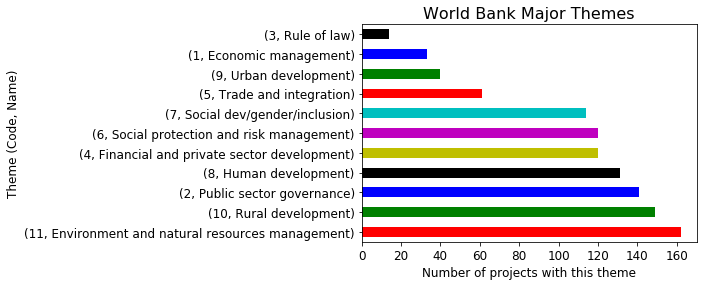

In [39]:
# Display a bar graph of the data.
xtitle = 'Number of projects with this theme'
bar_colors = 'rgbkymc'

ax = themes_count_df.plot(
                     kind='barh', 
                     legend=False, 
                     fontsize=12, 
                     color=bar_colors
                    )

ax.set_title('World Bank Major Themes', fontsize=16)
ax.set_ylabel('Theme (Code, Name)', fontsize=12)
ax.set_xlabel(xtitle, fontsize=12)

plt.show()

One of the nice things about pandas' matpyplot interface is that it automatically uses the index if I don't tell it what else to do, which is nice when the index contains a pair of columns.